In [5]:
# I. Data Exploring
# II. Preprocesing
# III. Algorithm choice
# IV. Tuning and Validation

import time
import treetaggerwrapper
import csv
import time
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from nltk.corpus import stopwords as sw

def load_file(file_name):
    reviews_l = []
    scores_l = []
    with open(file_name) as fp:
        lines = csv.reader(fp, delimiter=',')
        next(lines, None)  # skip the header
        for line in lines:
            reviews_l.append(line[0])
            scores_l.append(line[1])
    return reviews_l, scores_l

def load_evaluation_file(file_name):
    evaluation_review_l = []
    with open(file_name) as fp:
        lines = csv.reader(fp, delimiter=',')
        next(lines, None)  # skip the header
        for line in lines:
            evaluation_review_l.append(line[0])
    return evaluation_review_l

def print_to_file(filename, y_test_pred):
    filepath = './data/'+str(filename)+'.csv'
    with open(filepath, 'w') as fp:
        output_fp = csv.writer(fp, delimiter=',')
        output_fp.writerow(['Id', 'Predicted'])
        for i, label in enumerate(y_test_pred):
            output_fp.writerow([i, label])

    

reviews_l, scores_l = load_file("./data/development.csv")
evaluation_review_l = load_evaluation_file('./data/evaluation.csv')  


In [2]:
# DATA EXPLORING
from collections import Counter
    
c = Counter(scores_l)
print(c)
print("Pos: ", c['pos'], "->",c['pos']/len(scores_l))
print("neg", c['neg'], "->", c['neg']/len(scores_l))


Counter({'pos': 19532, 'neg': 9222})
Pos:  19532 -> 0.6792794046045768
neg 9222 -> 0.32072059539542325


In [28]:
# DATA EXPLORING
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

pos_reviews_l = []
neg_reviews_l = []

for review, label in zip(reviews_l, scores_l):
    if label == 'pos':
        pos_reviews_l.append(review)
    else:
        neg_reviews_l.append(review)
print("pos_reviews_l:",len(pos_reviews_l))
print("neg_reviews_l:",len(neg_reviews_l))
print(len(pos_reviews_l)+len(neg_reviews_l),"/",len(reviews_l))

pos_reviews_l: 19532
neg_reviews_l: 9222
28754 / 28754


In [3]:
# PREPROCESSING

class LemmaTokenizer1(object):
    def __init__(self):
        self.tg = treetaggerwrapper.TreeTagger(TAGLANG='it')

    def __call__(self, document):
        words_tokenized = self.tg.tag_text(document)
        tuples = treetaggerwrapper.make_tags(words_tokenized)
        lemmas = [t[-1] for t in tuples]
        return lemmas

# The most important difference is string.punctuation

class LemmaTokenizer2(object):
    def __init__(self):
        self.tg = treetaggerwrapper.TreeTagger(TAGLANG='it')
        self.emoji = [':)', ':(', '<3']

    def __call__(self, document):
        words_tokenized = self.tg.tag_text(document)
        tuples = treetaggerwrapper.make_tags(words_tokenized)
        lemmas = []
        for t in tuples:
            w = t[-1]
            if w not in string.punctuation or w in self.emoji:
                lemmas.append(w)
        return lemmas

In [72]:
# DATA EXPLORING
stop_words_l = sw.words('italian') + ['@card@', 'avra', 'avro', 'fara', 'faro', 'perche', 'piu', 'sara', 'saro', 'stara',
                                      'staro', 'avere', 'dare', 'dio', 'essere', 'fare', 'fossa', 'fosso', 'neo', 
                                      'stare', 'stesso','aglio', 'card', 'facciata', 'torre']

cv_pos = CountVectorizer(tokenizer=LemmaTokenizer2(),
                           stop_words=stop_words_l,
                           strip_accents='unicode',
                           lowercase=True,
                            max_df=0.7,
                          min_df=5)

cv_neg = CountVectorizer(tokenizer=LemmaTokenizer2(),
                           stop_words=stop_words_l,
                           strip_accents='unicode',
                           lowercase=True,
                            max_df=0.7,
                          min_df=5)

dt_pos = cv_pos.fit_transform(pos_reviews_l)
dt_neg = cv_neg.fit_transform(neg_reviews_l)

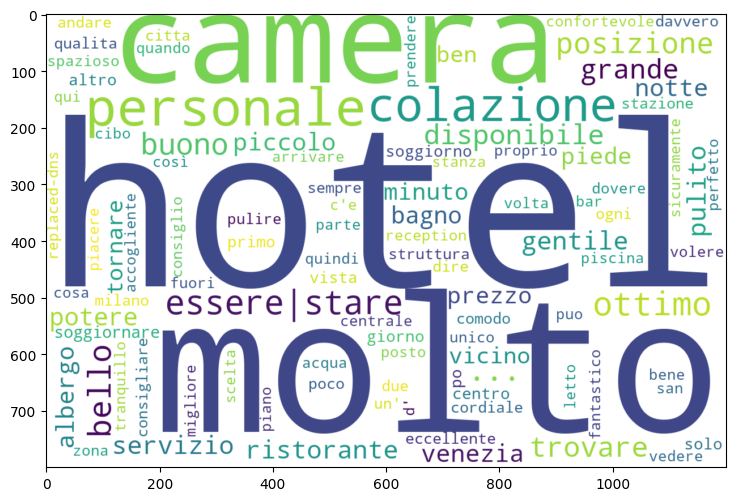

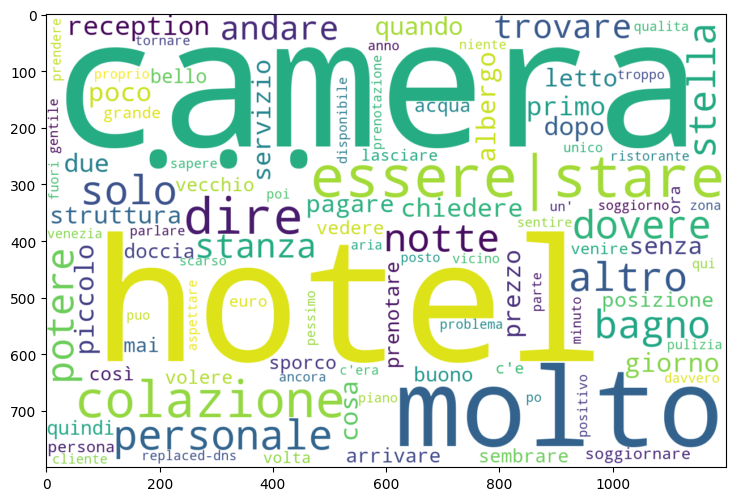

In [73]:
# DATA EXPLORING
pos_words_l = list(cv_pos.get_feature_names())
neg_words_l = list(cv_neg.get_feature_names())

dt_pos_sum = np.sum(dt_pos, axis=0)
dt_neg_sum = np.sum(dt_neg, axis=0)
dt_pos_sum = np.asarray(dt_pos_sum).reshape(-1)
dt_neg_sum = np.asarray(dt_neg_sum).reshape(-1)
top_indices_pos = dt_pos_sum.argsort()[-100:]
top_indices_neg = dt_neg_sum.argsort()[-100:]

term_weights_pos = {pos_words_l[i]: dt_pos_sum[i] for i in top_indices_pos}
term_weights_neg = {neg_words_l[i]: dt_neg_sum[i] for i in top_indices_neg}

wc_pos = WordCloud(width=1200, height=800, background_color="white")
wc_neg = WordCloud(width=1200, height=800, background_color="white")

wordcloud_pos = wc_pos.generate_from_frequencies(term_weights_pos)
wordcloud_neg = wc_neg.generate_from_frequencies(term_weights_neg)

fig_pos, ax_pos=plt.subplots(figsize=(10,6), dpi=100)
ax_pos.imshow(wordcloud_pos, interpolation='bilinear')

fig_pos, ax_neg=plt.subplots(figsize=(10,6), dpi=100)
ax_neg.imshow(wordcloud_neg, interpolation='bilinear')

In [6]:
# PREPROCESSING
# max_df = 0.3 min_df = 5 No Stop_words => 4068 words 
# LemmaTokenizer2 max_df = 0.7 min_df = 5 No Stop_words => 10689 words 
# LemmaTokenizer2 max_df = 0.7 min_df = 5 Yes Stop_words => 10595 words
# LemmaTokenizer2 max_df = 0.3 min_df = 5 Yes_Stop_words => 10589 words

# Best with stop_words
# certificato22 = 0.967 c=0.2, max_df=0.7 min_df=5 Tokenizer2 Yes_stop_words
t0 = time.time()   

stop_words_l = sw.words('italian') + ['@card@', 'avra', 'avro', 'fara', 'faro', 'perche', 'piu', 'sara', 'saro', 'stara',
                                      'staro', 'avere', 'dare', 'dio', 'essere', 'fare', 'fossa', 'fosso', 'neo', 
                                      'stare', 'stesso','aglio', 'card', 'facciata', 'torre']
    
vect2 = TfidfVectorizer(tokenizer=LemmaTokenizer2(),
                           stop_words=stop_words_l,
                           strip_accents='unicode',
                           lowercase=True,
                            max_df=0.7,
                          min_df=5)
tfidf_x2 = vect2.fit_transform(reviews_l) 

x_train2, x_test2, y_train2, y_test2 = train_test_split(tfidf_x2, scores_l, test_size=0.2)

print(f"Compute tfidf time: {(time.time() - t0):.2f} sec")

Compute tfidf time: 226.00 sec


In [ ]:
# I had thought if it made sense to normalize the tfidf, but I read that it would be better not to->
# https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features

In [90]:
# PREPROCESSING

print(tfidf_x2.shape)
print("Number of words/features: ", len(vect2.vocabulary_.keys()))

(28754, 10589)
Number of words/features:  10589


In [12]:
# PREPROCESSING

c1 = Counter(y_train2)
c2 = Counter(y_test2)
print("y_train:")
print("Pos: ", c1['pos'], "->", c1['pos']/len(y_train2))
print("Neg: ", c1['neg'], "->", c1['neg']/len(y_train2))
print("y_test:")
print("Pos: ", c2['pos'], "->", c2['pos']/len(y_test2))
print("Neg: ", c2['neg'], "->", c2['neg']/len(y_test2))

y_train:
Pos:  15644 -> 0.6800852062774421
Neg:  7359 -> 0.31991479372255793
y_test:
Pos:  3888 -> 0.676056338028169
Neg:  1863 -> 0.323943661971831


In [32]:
# Algorithm choise

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, classification_report

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest",
         "Naive Bayes"]

f1_l = []

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear"),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    GaussianNB()]

for name, clf in zip(names, classifiers):
    if(name == 'Naive Bayes'):
        a = x_train2.toarray()
        b = x_test2.toarray()
    else:
        a = x_train2
        b = x_test2

    clf.fit(a,y_train2)
    y_test_pred = clf.predict(b)
    print(f"**********************{name}*****************************")
    print(classification_report(y_test_pred, y_test2))
    print(confusion_matrix(y_test_pred, y_test2))
    f1 = f1_score(y_test2, y_test_pred, average='weighted')
    f1_l.append(f1)
    print(f"F1: {f1}")
    print("*************************************************************")

**********************Nearest Neighbors*****************************
              precision    recall  f1-score   support

         neg       0.74      0.75      0.75      1745
         pos       0.89      0.88      0.89      4006

    accuracy                           0.84      5751
   macro avg       0.82      0.82      0.82      5751
weighted avg       0.85      0.84      0.84      5751

[[1313  432]
 [ 463 3543]]
F1: 0.8439920464032991
*************************************************************
**********************Linear SVM*****************************
              precision    recall  f1-score   support

         neg       0.94      0.94      0.94      1781
         pos       0.97      0.97      0.97      3970

    accuracy                           0.96      5751
   macro avg       0.96      0.96      0.96      5751
weighted avg       0.96      0.96      0.96      5751

[[1669  112]
 [ 107 3863]]
F1: 0.9619344480228316
*****************************************************

In [33]:
# I choose SVC(kernel='linear') due to the f1 results in the previus cell.
# Now I try to improve SVC by tuning its params.
# I choose LinearSVC because its faster than SVC(kernel='linear') in my experiments.

# Also note that for the linear case, the algorithm used in LinearSVC by the liblinear implementation is much 
# more efficient than its libsvm-based SVC counterpart and can scale almost linearly to millions of 
# samples and/or features.

# To build a robust and reliable classification model a cross validation on the data available in 
# the development set is performed.

[0.9587628119682919, 0.9606548428361673, 0.9604354260423674, 0.9597901498519735, 0.9593366071906013, 0.9591323008980585, 0.9588263688047701, 0.9585870107025422, 0.9583155389227613, 0.957797205322449, 0.9574848114931954, 0.9573139118941337, 0.9568945339356411, 0.9567221745985396, 0.9564447368659494, 0.9560293992087693, 0.9558534154055468, 0.9552642261699568, 0.9550907568101015, 0.9550895574752886]


Text(0, 0.5, 'Cross-Validated Accuracy')

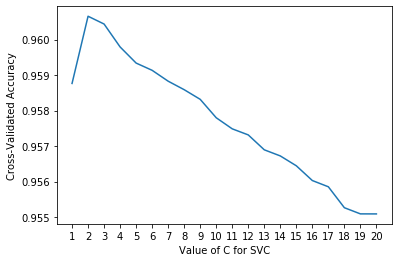

In [7]:
# TUNING AND VALIDATION
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import make_scorer

acc_score=[]
c_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
for c in range(20):
    svc = LinearSVC(C=c_values[c])
    scores = cross_val_score(svc, tfidf_x2, scores_l, cv=3, scoring=make_scorer(f1_score, average='weighted')) # 'accuracy'
    acc_score.append(scores.mean())
print(acc_score)    

C_values=list(range(1,21))
# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(C_values,acc_score)
plt.xticks(C_values)
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy')

In [9]:
# I get the best score for C=0.2
acc_score[1]

0.9606548428361673

In [10]:
# TUNING AND VALIDATION
# class_weight={'pos':1.2,'neg':1.3}
clf = LinearSVC(C=0.2)
clf.fit(x_train2, y_train2)
y_test_pred = clf.predict(x_test2)

print(confusion_matrix(y_test2, y_test_pred))
print(classification_report(y_test_pred, y_test2))
f1 = f1_score(y_test2, y_test_pred, average='weighted')
print(f"F1 loro: {f1}")

[[1713  138]
 [  68 3832]]
              precision    recall  f1-score   support

         neg       0.93      0.96      0.94      1781
         pos       0.98      0.97      0.97      3970

    accuracy                           0.96      5751
   macro avg       0.95      0.96      0.96      5751
weighted avg       0.96      0.96      0.96      5751

F1 loro: 0.9639942627493301


In [11]:
# SVM - FEATURES IMPORTANCE
# The primary advantage of linear models over neural networks (a non linear model) is that the feature weights
# directly correspond to the importance of the feature within the model. 
# Thus it is easy to understand what the model has learned.

# For “one-vs-rest” LinearSVC the attributes coef_ and intercept_ have the shape [n_class, n_features] and 
# [n_class] respectively. Each row of the coefficients corresponds to one of the n_class many “one-vs-rest” 
# classifiers and similar for the intercepts, in the order of the “one” class.

# clf.coef_ Weights assigned to the features 
print("num of coef: ", clf.coef_.shape)
print("Intercept: ", clf.intercept_)


index_max = np.argmax(clf.coef_)
index_min = np.argmin(clf.coef_)
np.max(clf.coef_)
words2 = list(vect2.vocabulary_.keys())
print("max coef", np.max(clf.coef_), "->", words2[index_max])
print("min coef", np.min(clf.coef_), "->", words2[index_min])

ind = clf.coef_.argsort() #[-10:][::-1]

ind = list(ind[0])
index_min = ind[0:10]
index_max = ind[:len(ind)-11:-1]

print("More important words:")
for i in range(len(index_max)):
    print(clf.coef_[0][index_max[i]], "->", words2[index_max[i]])

print()
print("Less important words:")
for i in range(len(index_min)):
    print(clf.coef_[0][index_min[i]], "->", words2[index_min[i]])
    

num of coef:  (1, 10595)
Intercept:  [-0.04766342]
max coef 2.880360166334428 -> valdostano
min coef -2.6498800628652974 -> testimoniare
More important words:
2.880360166334428 -> valdostano
2.453214762947466 -> accoccolare
2.256105896894239 -> anteguerra
1.7978175103861975 -> bridge
1.7799192468005927 -> bocchettone
1.7342988445261376 -> bad
1.6676635598533613 -> relativamente
1.517353599660517 -> palco
1.5136199185537584 -> flora
1.5081252595482533 -> g

Less important words:
-2.6498800628652974 -> testimoniare
-2.601847638080301 -> verdurine
-2.5278626272722233 -> pozzo
-2.2468812814483674 -> ehi
-1.9134638188879636 -> cigno
-1.6802247025114105 -> parrucchiera|parrucchiere
-1.6301274875367144 -> cattolico
-1.5887953543036002 -> toccasana
-1.5693441009667641 -> fioriera
-1.5676289517254762 -> squallido


In [12]:
# Certificato14 = 0.969 C=0.3 max_df=0.99, min_df=0.001 Tokenizer1 No_Stop_words
# certificato15 = 0.968 C=0.4 max_df=0.99, min_df=0.001 Tokenizer1 No_Stop_words

# certificato18 = 0.966 c=0.3, max_df=0.3 min_df=5 Tokenizer2 No_Stop_words
# certificato19 = 0.965 c=0.4, max_df=0.3 min_df=5 Tokenizer2 No_Stop_words
# certificato20 = 0.968 c=0.4, max_df=0.7 min_df=5 Tokenizer2 No_Stop_words

# certificato21 = 0.965 c=0.4, max_df=0.7 min_df=5 Tokenizer2 Yes_stop_words  
# certificato22 = 0.967 c=0.2, max_df=0.7 min_df=5 Tokenizer2 Yes_stop_words
# certificato23 = 0.965 c=0.2, max_df=0.3 min_df=5 Tokenizer2 Yes_stop_words
# certificato24 = 0.965 c=0.3, max_df=0.3 min_df=5 Tokenizer2 Yes_stop_words
import time
from sklearn.svm import LinearSVC

t0 = time.time()    

stop_words_l = sw.words('italian') + ['@card@', 'avra', 'avro', 'fara', 'faro', 'perche', 'piu', 'sara', 'saro', 'stara',
                                      'staro', 'avere', 'dare', 'dio', 'essere', 'fare', 'fossa', 'fosso', 'neo', 
                                      'stare', 'stesso','aglio', 'card', 'facciata', 'torre']
    
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=LemmaTokenizer2(),
                       stop_words=stop_words_l,
                       strip_accents='unicode',
                       max_df=0.7,
                       min_df=5,
                       lowercase=True)), 
    ('clf', LinearSVC(C=0.2)),  
])

pipeline.fit(reviews_l,scores_l)

y_test_pred = pipeline.predict(evaluation_review_l)

with open('./data/certificate25.csv', 'w') as fp:
    output_fp = csv.writer(fp, delimiter=',')
    output_fp.writerow(['Id', 'Predicted'])
    for i, label in enumerate(y_test_pred):
        output_fp.writerow([i, label])

print(f"Time: {(time.time() - t0):.2f} sec")

Time: 335.78 sec


In [99]:
print(len(stop_words_l))
print(stop_words_l)

304
['ad', 'al', 'allo', 'ai', 'agli', 'all', 'agl', 'alla', 'alle', 'con', 'col', 'coi', 'da', 'dal', 'dallo', 'dai', 'dagli', 'dall', 'dagl', 'dalla', 'dalle', 'di', 'del', 'dello', 'dei', 'degli', 'dell', 'degl', 'della', 'delle', 'in', 'nel', 'nello', 'nei', 'negli', 'nell', 'negl', 'nella', 'nelle', 'su', 'sul', 'sullo', 'sui', 'sugli', 'sull', 'sugl', 'sulla', 'sulle', 'per', 'tra', 'contro', 'io', 'tu', 'lui', 'lei', 'noi', 'voi', 'loro', 'mio', 'mia', 'miei', 'mie', 'tuo', 'tua', 'tuoi', 'tue', 'suo', 'sua', 'suoi', 'sue', 'nostro', 'nostra', 'nostri', 'nostre', 'vostro', 'vostra', 'vostri', 'vostre', 'mi', 'ti', 'ci', 'vi', 'lo', 'la', 'li', 'le', 'gli', 'ne', 'il', 'un', 'uno', 'una', 'ma', 'ed', 'se', 'perché', 'anche', 'come', 'dov', 'dove', 'che', 'chi', 'cui', 'non', 'più', 'quale', 'quanto', 'quanti', 'quanta', 'quante', 'quello', 'quelli', 'quella', 'quelle', 'questo', 'questi', 'questa', 'queste', 'si', 'tutto', 'tutti', 'a', 'c', 'e', 'i', 'l', 'o', 'ho', 'hai', 'ha',

In [101]:
stopwords = require('stopwords-it');


NameError: name 'require' is not defined